In [13]:
!pip install statsmodels
!pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 7.6 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

In [4]:

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print(train_data.head())
print(test_data.head())

   time         A         B         C         D         E         F         G  \
0     0  0.207366 -0.159951 -0.634176 -0.580962 -0.266505  0.060173 -0.475257   
1     1  0.188828 -0.265508  0.042143 -0.550442 -0.132319 -0.185219  0.028295   
2     2 -0.144261 -0.577142 -0.214634 -0.747391 -0.184255 -0.464831 -0.085181   
3     3  0.208982 -0.310449  0.513708 -0.562868  0.742308 -0.305487  0.762246   
4     4  0.093320 -0.358156  0.173188 -0.687296 -0.161461 -0.116062 -0.245748   

          H         I         J         K         L         M         N  \
0 -1.486516 -0.332594 -0.671466 -0.226149 -0.187624 -0.780237 -0.785965   
1  0.093210 -0.518139 -0.251917 -0.347845 -0.359069 -0.161254  0.020401   
2  0.700449 -0.603438  0.197773 -0.566696 -0.580799  0.202726  0.135261   
3  1.363020 -0.384575  0.525556 -0.348514 -0.428099  0.548993  0.471031   
4  0.863372 -0.655588 -0.263358 -0.557428 -0.481214  0.083602  0.003087   

         Y1        Y2  
0 -0.935902 -0.310081  
1 -0.089707 -0

Exploratory Data anlaysis

In [5]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    80000 non-null  int64  
 1   A       80000 non-null  float64
 2   B       80000 non-null  float64
 3   C       80000 non-null  float64
 4   D       80000 non-null  float64
 5   E       80000 non-null  float64
 6   F       80000 non-null  float64
 7   G       80000 non-null  float64
 8   H       80000 non-null  float64
 9   I       80000 non-null  float64
 10  J       80000 non-null  float64
 11  K       80000 non-null  float64
 12  L       80000 non-null  float64
 13  M       80000 non-null  float64
 14  N       80000 non-null  float64
 15  Y1      80000 non-null  float64
 16  Y2      80000 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 10.4 MB


In [8]:
numeric = train_data.select_dtypes(include=[np.number]).columns.tolist()
corr = train_data[numeric].corr()
corr_y1 = corr["Y1"].drop("Y1").sort_values(ascending=False)
corr_y2 = corr["Y2"].drop("Y2").sort_values(ascending=False)
print("\nTop corr with Y1:\n", corr_y1.head(15))
print("\nTop corr with Y2:\n", corr_y2.head(15))


Top corr with Y1:
 G       0.814568
J       0.723921
H       0.707560
C       0.703823
M       0.686246
E       0.684297
N       0.595766
time   -0.005645
A      -0.006105
D      -0.057097
Y2     -0.064250
L      -0.072366
F      -0.073191
K      -0.080196
I      -0.090226
Name: Y1, dtype: float64

Top corr with Y2:
 D       0.611063
K       0.599183
B       0.581859
I       0.508347
L       0.503546
F       0.496667
A       0.484746
time    0.059143
E      -0.044583
G      -0.060187
Y1     -0.064250
C      -0.073009
N      -0.080172
H      -0.086976
M      -0.095326
Name: Y2, dtype: float64


In [17]:
def fast_adf(series, maxlag=20):
    stat, pval, lags, nobs, _ = adfuller(series, maxlag=maxlag, regression='c', autolag=None)
    return {"adf_stat": stat, "p_value": pval, "lags_used": lags, "n_obs": nobs}

for tgt in ["Y1", "Y2"]:
    res = fast_adf(train_data[tgt], maxlag=20)
    print(f"\nADF ({tgt}):", res)


ADF (Y1): {'adf_stat': np.float64(-61.03215242872858), 'p_value': 0.0, 'lags_used': 20, 'n_obs': 79979}

ADF (Y2): {'adf_stat': np.float64(-36.56734101996724), 'p_value': 0.0, 'lags_used': 20, 'n_obs': 79979}


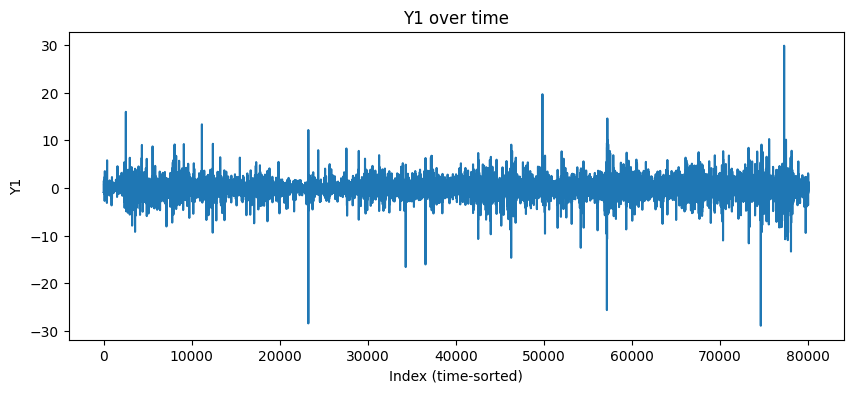

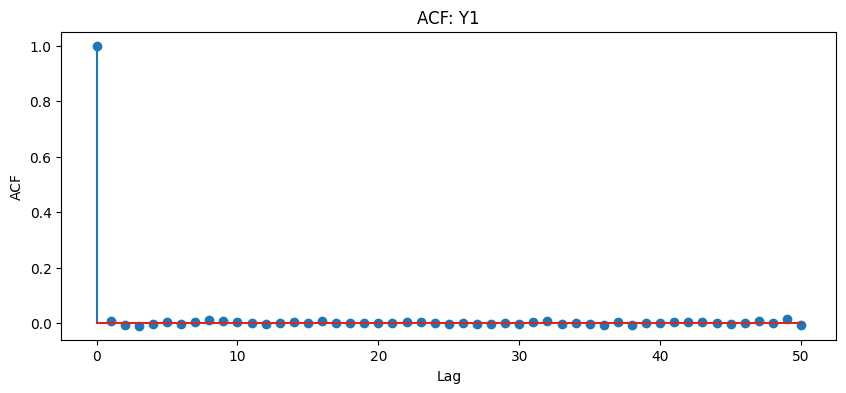

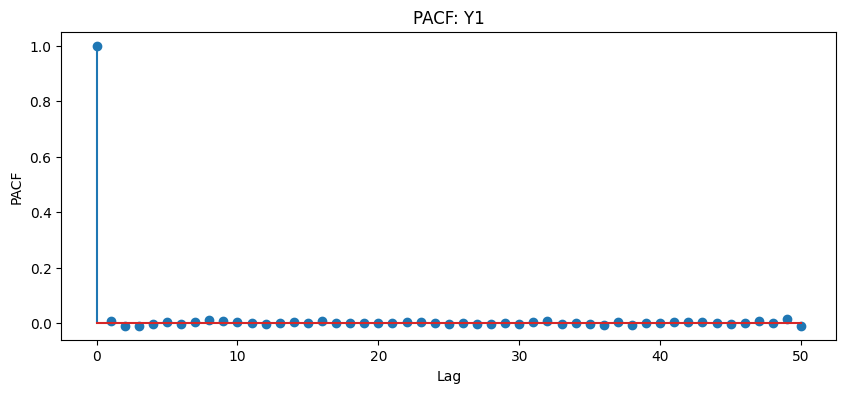

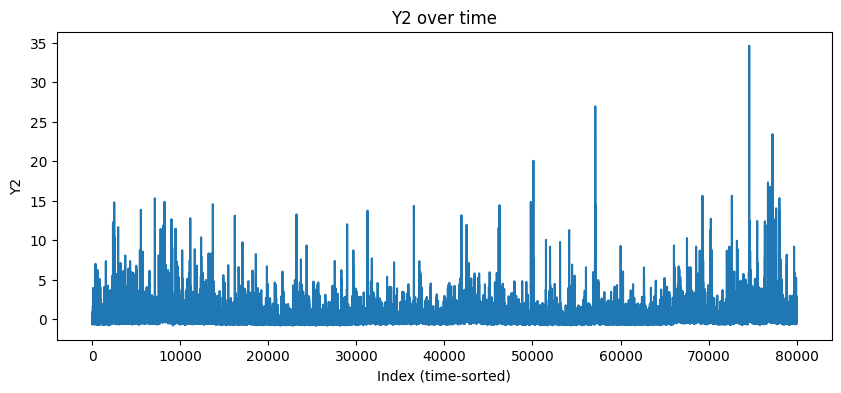

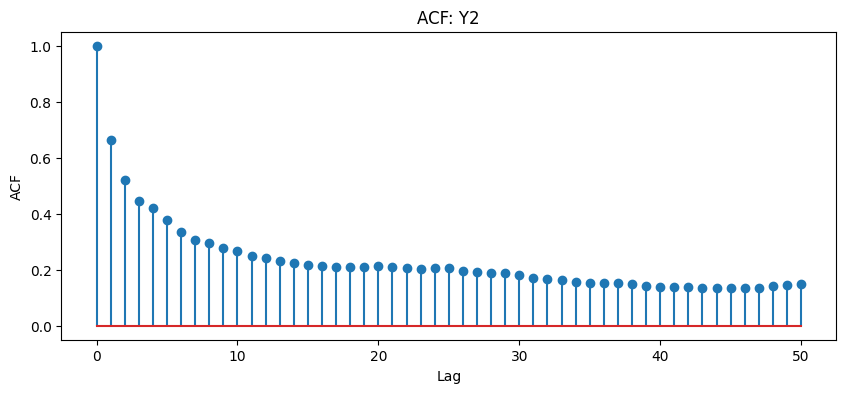

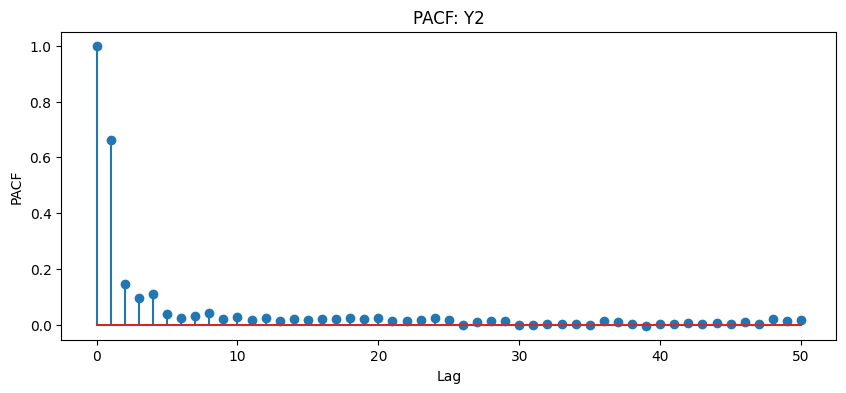

In [20]:
def show_plots(y, name, max_lag=50):
    # --- Time series ---
    plt.figure(figsize=(10,4))
    plt.plot(y.values)
    plt.title(f"{name} over time")
    plt.xlabel("Index (time-sorted)")
    plt.ylabel(name)
    plt.show()
    
    # --- ACF ---
    a = acf(y, nlags=max_lag, fft=True)
    plt.figure(figsize=(10,4))
    plt.stem(range(len(a)), a)
    plt.title(f"ACF: {name}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

    # --- PACF ---
    p = pacf(y, nlags=max_lag, method='ywm')
    plt.figure(figsize=(10,4))
    plt.stem(range(len(p)), p)
    plt.title(f"PACF: {name}")
    plt.xlabel("Lag")
    plt.ylabel("PACF")
    plt.show()

# Run for Y1 and Y2
show_plots(train_data["Y1"], "Y1")
show_plots(train_data["Y2"], "Y2")

Y1
	•	ACF/PACF: “not fluctuating a lot” ⇒ weak serial dependence; today’s Y1 doesn’t strongly depend on its own past.
	•	Feature correlations: “top 4 quite high” with A–N ⇒ Y1 is mostly contemporaneously explained by current market features.
	•	Takeaway: You don’t need long histories or sequence models to explain Y1. A strong tabular regressor on current (plus a few short lags of A–N if you like) should get you high R². Linear models may already be competitive; nonlinear GBMs can squeeze out extra variance explained.

Y2
	•	ACF & PACF: “above the line” (many significant lags) ⇒ strong persistence/serial structure.
	•	Feature correlations: “not as high” ⇒ current A–N alone don’t explain Y2 well.
	•	BUT the test set doesn’t contain Y lags, so you cannot use lagged Y2/Y1 directly.
	•	Takeaway: You must encode memory through the features A–N (lags/rolling stats/differences). Models that leverage many lagged/derived inputs and capture nonlinear interactions will shine.
